# Data Preparation

In this sectiono we load in and prepare the data for our machine learning.

## Import Statements

!pip install scipy
!pip install pandas
!pip install scikit-learn

!conda install -c conda-forge cudatoolkit=11.2 cudnn=8.1.0
# Anything above 2.10 is not supported on the GPU on Windows Native
!pip install "tensorflow<2.11"


!pip list
!pip install -q seaborn

In [2]:
import os
import scipy.io as sio
import pandas as pd
from scipy.io import loadmat
import datetime
from pandas import DataFrame
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

np.set_printoptions(precision=3, suppress=True)

In [3]:
def plot_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error')
    plt.plot(history.epoch, np.array(history.history['mae']), 
             label='Train')
    plt.plot(history.epoch, np.array(history.history['val_mae']),
             label = 'Val')
    plt.legend()
    # plt.ylim([0,max(history.history['val_mae']) + 1])
    
def plot_prediction(test_labels, test_predictions):
    plt.figure()
    plt.scatter(test_labels, test_predictions)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    _ = plt.plot([-100, 100],[-100,100])
    
    plt.figure()
    error = test_predictions - test_labels
    plt.hist(error, bins = 50)
    plt.xlabel("Prediction Error")
    _ = plt.ylabel("Count")

## Ingesting the data

The following data is from a Nasa dataset with n refferring to the iteration number of the dataset used. 
Temperature is in celcius
Voltage is in volts
Current is in Amps

In [4]:
n = 'B0005'
df = pd.read_csv('data_frames/' + 'NASA_cycle_dataset_' + n +'.csv',
                 parse_dates = ["datetime"]).drop(["Unnamed: 0"], axis = 1)
df.head()

,cycle,ambient_temperature,datetime,voltage_measured,current_measured,temperature_measured,current,voltage,time,capacity
0,1,24,2008-04-02 13:08:17,3.873017,-0.001201,24.655358,0.000,0.003,0.000,NaN
1,1,24,2008-04-02 13:08:17,4.206466,0.060136,24.241571,0.057,4.250,5314.703,NaN
2,1,24,2008-04-02 13:08:17,4.206558,0.057209,24.230457,0.057,4.250,5329.485,NaN
3,1,24,2008-04-02 13:08:17,4.205512,0.050194,24.241984,0.047,4.245,5344.282,NaN
4,1,24,2008-04-02 13:08:17,4.205301,0.047004,24.226732,0.047,4.245,5359.141,NaN


## Beginning Data engineering

In the Below cells we are attempting to fill in the missing values. A brief look at the dataset showed that each cycle potentially had a capacity for at least one of its rows. 

First we test that theory:

In [5]:
capacity_counts = pd.DataFrame(df.groupby('cycle')['capacity'].nunique())
zero_capacity_rows = capacity_counts[capacity_counts['capacity'] != 1]
# capacity_counts
zero_capacity_rows

,capacity
cycle,
169,0
170,0


In [6]:
cap_std = df['capacity'].std()
cap_mean = df['capacity'].mean()

print(f"The standard deviation of capacity is {round(cap_std, 4)}.")
print(f"The average of capacity is {round(cap_mean, 4)}.")
print(f"This makes the standard deviation {round(cap_std/cap_mean*100,2)}% of the mean")

The standard deviation of capacity is 0.1824.
The average of capacity is 1.5603.
This makes the standard deviation 11.69% of the mean


The above cell shows that there is a singular battery capacity for each cycle except for 169 and 170.
For now we shall remove those two cycles as there is a large amount of deviation.

In [7]:
df = df[df['cycle'] <  169]
caps = pd.DataFrame(df.groupby('cycle')['capacity'].max())
temp = df.merge(caps, on='cycle', how='left').ffill()
temp = temp.drop(["capacity_x"], axis = 1).rename(columns = {"capacity_y" : "capacity"})
df = temp
temp.head()

,cycle,ambient_temperature,datetime,voltage_measured,current_measured,temperature_measured,current,voltage,time,capacity
0,1,24,2008-04-02 13:08:17,3.873017,-0.001201,24.655358,0.000,0.003,0.000,1.856487
1,1,24,2008-04-02 13:08:17,4.206466,0.060136,24.241571,0.057,4.250,5314.703,1.856487
2,1,24,2008-04-02 13:08:17,4.206558,0.057209,24.230457,0.057,4.250,5329.485,1.856487
3,1,24,2008-04-02 13:08:17,4.205512,0.050194,24.241984,0.047,4.245,5344.282,1.856487
4,1,24,2008-04-02 13:08:17,4.205301,0.047004,24.226732,0.047,4.245,5359.141,1.856487


In [8]:
df['ambient_temperature'].nunique()

1

# Machine Learning (CNN)

Now we begin to build our Convolutional Neural Network

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, r2_score
from tensorflow import keras
import warnings

In [10]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [11]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [12]:
prep_df = df.drop(['datetime', 'ambient_temperature'], axis = 1)
train_dataset = prep_df.sample(frac=0.8, random_state = 0)
test_dataset = prep_df.drop(train_dataset.index)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sns.pairplot(train_dataset.iloc[:,0:8], diag_kind='kde')

In [13]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
cycle,470279.0,95.409219,42.773598,1.000000,60.000000,96.000000,132.000000,168.000000
voltage_measured,470279.0,4.103417,0.213988,2.471315,4.087904,4.205138,4.205908,8.393141
current_measured,470279.0,0.368345,0.909263,-4.479660,0.039531,0.171773,1.262020,1.530376
temperature_measured,470279.0,26.375203,2.778615,23.214802,24.489668,25.483638,27.353169,41.450232
current,470279.0,0.635250,0.737908,-4.468000,0.057000,0.261000,1.498000,1.998400
voltage,470279.0,4.021478,1.213135,0.000000,4.240000,4.305000,4.656000,5.002000
time,470279.0,4763.490005,3149.187573,0.000000,1925.390000,4464.735000,7504.617000,10807.328000
capacity,470279.0,1.531792,0.171983,1.287453,1.370513,1.511898,1.694580,1.856487


## Normalisation

Here we will normalise the values to give equal weight to each feature

In [14]:
# Test data is *not* used when calculating the mean and std.
mean = train_dataset.mean(axis=0)
std = train_dataset.std(axis=0)
train_dataset = (train_dataset - mean) / std
test_dataset = (test_dataset - mean) / std

train_dataset.head()  # First training sample, normalized

,cycle,voltage_measured,current_measured,temperature_measured,current,voltage,time,capacity
489563,1.135999,-0.143625,1.256087,0.209200,1.171893,0.656582,-1.210051,-1.150031
383688,0.528148,0.459574,-0.405123,-0.703511,-0.860880,-3.312475,1.750762,-0.693171
580550,1.673714,0.477536,-0.315329,-0.783674,-0.752465,0.197441,0.651887,-1.295344
110450,-1.038239,0.484418,-0.371263,-0.158716,-0.818869,0.180130,1.413676,1.309582
354820,0.364495,0.485901,0.844907,1.435609,0.670476,0.621137,-0.755598,-0.541457


In [15]:
# These are the features
train_features = train_dataset.copy()
test_features = test_dataset.copy()
print(train_features.iloc[0])
# These contain the target variables
train_labels = train_features.pop('capacity')
test_labels = test_features.pop('capacity')
print('--------------------------')
print(train_features.iloc[0])

cycle                   1.135999
voltage_measured       -0.143625
current_measured        1.256087
temperature_measured    0.209200
current                 1.171893
voltage                 0.656582
time                   -1.210051
capacity               -1.150031
Name: 489563, dtype: float64
--------------------------
cycle                   1.135999
voltage_measured       -0.143625
current_measured        1.256087
temperature_measured    0.209200
current                 1.171893
voltage                 0.656582
time                   -1.210051
Name: 489563, dtype: float64


In [16]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
cycle,6.360873e-18,1.0
voltage_measured,7.483952e-15,1.0
current_measured,1.155836e-16,1.0
temperature_measured,1.024327e-15,1.0
current,2.446443e-16,1.0
voltage,3.908991e-16,1.0
time,-1.105674e-16,1.0
capacity,-1.998613e-16,1.0


## Regression with CNN

## Reshaping the Data

Conv1D layer expects input shape in 3D as

  `[batch_size, time_steps, input_dimension]`

However, current data is in the shape of

`[batch_size, features]`

so therefore must be reshaped. See below:

In [17]:
print(train_features.shape)
print(train_features.iloc[0].shape)
print(train_features.iloc[0].squeeze())

(470279, 7)
(7,)
cycle                   1.135999
voltage_measured       -0.143625
current_measured        1.256087
temperature_measured    0.209200
current                 1.171893
voltage                 0.656582
time                   -1.210051
Name: 489563, dtype: float64


In [18]:
sample_size = train_features.shape[0] # number of samples in train set
time_steps  = train_features.shape[1] # number of features in train set
input_dimension = 1               # each feature is represented by 1 number

train_features_reshaped = train_features.values.reshape(sample_size,time_steps,input_dimension)
print("After reshape train data set shape:\n", train_features_reshaped.shape)
print("1 Sample shape:\n",train_features_reshaped[0].shape)
print("An example sample:\n", train_features_reshaped[0])

After reshape train data set shape:
 (470279, 7, 1)
1 Sample shape:
 (7, 1)
An example sample:
 [[ 1.136]
 [-0.144]
 [ 1.256]
 [ 0.209]
 [ 1.172]
 [ 0.657]
 [-1.21 ]]


In [19]:
test_features_reshaped = test_features.values.reshape(test_features.shape[0],test_features.shape[1],1)

## Defining the Model

def build_conv1D_model():

    n_timesteps = train_features_reshaped.shape[1] #7
    n_features  = train_features_reshaped.shape[2] #1 
    model = keras.Sequential(name="model_conv1D")
    # model.add(norm)
    model.add(keras.layers.Input(shape=(n_timesteps,n_features)))
    model.add(keras.layers.Conv1D(filters=64, kernel_size=6, activation='relu', name="Conv1D_1"))
    model.add(keras.layers.Dropout(0.5))
    # model.add(keras.layers.Conv1D(filters=32, kernel_size=4, activation='relu', name="Conv1D_2"))
    
    # model.add(keras.layers.Conv1D(filters=16, kernel_size=1, activation='relu', name="Conv1D_3"))
    
    model.add(keras.layers.MaxPooling1D(pool_size=2, name="MaxPooling1D"))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(32, activation='relu', name="Dense_1"))
    model.add(keras.layers.Dense(n_features, name="Dense_2"))
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    model.compile(loss='mse',optimizer=optimizer,metrics=['mae'])
    return model

In [48]:
def build_conv1D_model():

    n_timesteps = train_features_reshaped.shape[1] #7
    n_features  = train_features_reshaped.shape[2] #1 
    
    model = keras.Sequential(name="model_conv1D")
    model.add(keras.layers.Conv1D(32, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(keras.layers.MaxPooling1D(pool_size=2))
    model.add(keras.layers.Conv1D(32, kernel_size=2, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(keras.layers.MaxPooling1D(pool_size=1))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(1, activation='relu'))
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    model.compile(loss='mse', optimizer=optimizer, metrics=['mean_squared_error', 'mean_absolute_error'])
    return model

def plot_loss(history, title):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    # plt.ylim([0, 1])
    plt.xlabel('Epoch')
    plt.ylabel('Error [SOC]')
    plt.title(title)
    plt.legend()
    plt.grid(True)

In [49]:
model_conv1D = build_conv1D_model()
model_conv1D.summary()

Model: "model_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 5, 32)             128       
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 2, 32)            0         
 1D)                                                             
                                                                 
 conv1d_9 (Conv1D)           (None, 1, 32)             2080      
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 1, 32)            0         
 1D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                

In [50]:
epochs = 30
checkpoint_filepath = 'checkpoints\CNN{epoch:02d}-{val_loss:.4f}.h5'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='mean_squared_error',
    mode='min',
    save_best_only=True)

if 'history' not in locals():
    print('New History array has been created')
    history =  []

In [51]:
%%time
history.append(model_conv1D.fit(train_features_reshaped, train_labels, epochs=epochs,
                    validation_split=0.2, verbose=True, callbacks = model_checkpoint_callback))

Epoch 1/30
11757/11757 [==============================] - 86s 7ms/step - loss: 0.4517 - mean_squared_error: 0.4517 - mean_absolute_error: 0.4720 - val_loss: 0.4509 - val_mean_squared_error: 0.4509 - val_mean_absolute_error: 0.4653
Epoch 2/30
11757/11757 [==============================] - 86s 7ms/step - loss: 0.4484 - mean_squared_error: 0.4484 - mean_absolute_error: 0.4642 - val_loss: 0.4503 - val_mean_squared_error: 0.4503 - val_mean_absolute_error: 0.4627
Epoch 3/30
11757/11757 [==============================] - 84s 7ms/step - loss: 0.4481 - mean_squared_error: 0.4481 - mean_absolute_error: 0.4626 - val_loss: 0.4505 - val_mean_squared_error: 0.4505 - val_mean_absolute_error: 0.4630
Epoch 4/30
11757/11757 [==============================] - 88s 7ms/step - loss: 0.4479 - mean_squared_error: 0.4479 - mean_absolute_error: 0.4615 - val_loss: 0.4500 - val_mean_squared_error: 0.4500 - val_mean_absolute_error: 0.4614
Epoch 5/30
11757/11757 [==============================] - 85s 7ms/step - los

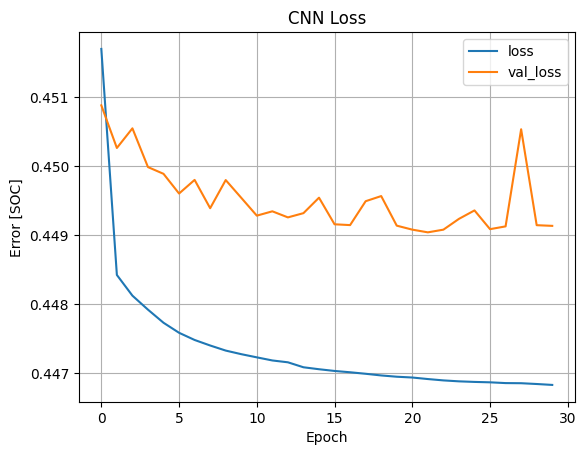

In [52]:
plot_loss(history[-1], 'CNN Loss')

In [53]:
model_path = os.path.join("models","CNN_02.keras")

In [54]:
model_conv1D.save(model_path)

In [55]:
model_conv1D = keras.models.load_model(model_path)

### Performance

In [56]:
# pd.DataFrame(history, index=['Mean absolute error [capacity]']).T

### Make Predictions

In [57]:
test_predictions = model_conv1D.predict(test_features_reshaped).flatten()

3675/3675 [==============================] - 7s 2ms/step


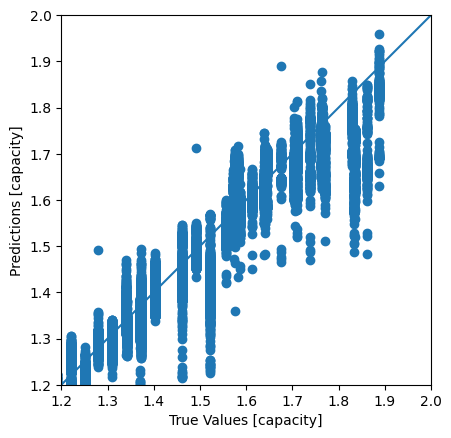

In [58]:
a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [capacity]')
plt.ylabel('Predictions [capacity]')
lims = [1.2, 2]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

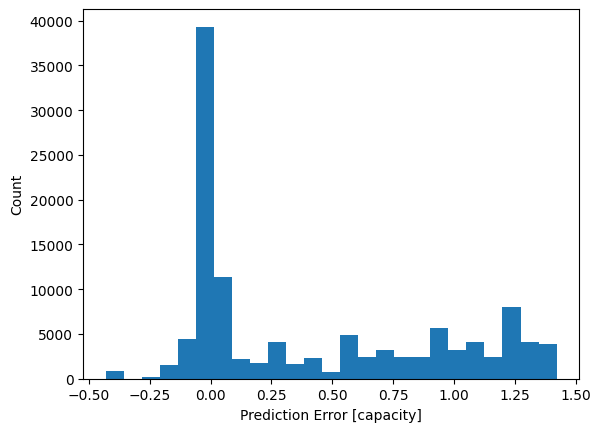

In [59]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [capacity]')
_ = plt.ylabel('Count')

In [60]:
# Calculate metrics
mse = mean_squared_error(test_labels, test_predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_labels, test_predictions)
r2 = r2_score(test_labels, test_predictions)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'R2 Score: {r2}')

MSE: 0.4491796637305588
RMSE: 0.6702086717810796
MAE: 0.45607405154775427
R2 Score: 0.550734507449029
